In [40]:
!jupyter kernelspec list
import torch 
use_cuda = torch. cuda. is_available()
print(use_cuda)

Available kernels:
  python3    D:\anaconda\envs\mnist\share\jupyter\kernels\python3
True


In [41]:
import sys
print(sys.executable)  # This should point to your virtual environment’s Python
print(sys.path)
#!pip install --upgrade torch


D:\anaconda\envs\mnist\python.exe
['D:\\anaconda\\envs\\mnist\\python39.zip', 'D:\\anaconda\\envs\\mnist\\DLLs', 'D:\\anaconda\\envs\\mnist\\lib', 'D:\\anaconda\\envs\\mnist', '', 'C:\\Users\\hvory\\AppData\\Roaming\\Python\\Python39\\site-packages', 'D:\\anaconda\\envs\\mnist\\lib\\site-packages', 'D:\\anaconda\\envs\\mnist\\lib\\site-packages\\win32', 'D:\\anaconda\\envs\\mnist\\lib\\site-packages\\win32\\lib', 'D:\\anaconda\\envs\\mnist\\lib\\site-packages\\Pythonwin', 'D:\\anaconda\\envs\\mnist\\lib\\site-packages\\setuptools\\_vendor']


In [42]:
#%%capture
#!pip install tqdm
#!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121
#!pip install matplotlib
#!pip install tqdm
#!pip install numpy==1.24.0
#!pip install --user --upgrade huggingface_hub huggingface
#!pip install huggingface_hub
!pip install ipywidgets
#!pip install --user diffusers
#!pip show huggingface_hub
# !pip show diffusers
# !pip show ipywidgets
# !pip show huggingface
# !pip show accelerate
# !pip show diffusers
#from diffusers.models.autoencoders import AutoencoderKL
#from transformers import AutoImageProcessor
#!pip install --upgrade pydevd

In [1]:
from dataclasses import dataclass
import torchvision
import torch
import os
import shutil
import diffusers
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import UNet2DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator
#from diffusers.utils.hub_utils import init_git_repo, push_to_hub
from datetime import datetime
import torch.nn.functional as F
from tqdm.auto import tqdm
from diffusers import DDPMPipeline
import numpy
import math
from accelerate import notebook_launcher
from diffusers import DDPMPipeline
import glob
from torchvision.utils import save_image
from torchvision import datasets
from diffusers import DiffusionPipeline

In [2]:
@dataclass
class TrainingConfig:
    image_size = 28  # the generated image resolution
    train_batch_size = 16 #48
    eval_batch_size = 16 #48  # how many images to sample during evaluation
    test_batch_size=1
    num_epochs = 35
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 5
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir ='C:\\Users\\hvory\\ISSBA-main\\MNist\\mnist'  # the model namy locally and on the HF Hub
    log_dir="log"
    workers = 4

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [3]:
data_transforms = {
        'train': transforms.Compose([
            #transforms.RandomRotation(20),
           # transforms.RandomHorizontalFlip(0.5),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            #transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]),
        'val': transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((64, 64)),
            #transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ])
    }
data_dir="C:\\Users\\hvory\\ISSBA-main\\MNist\\mnist"
#bd_data_dir= "/scratch/project_2012241/bd_dataset/"
image_datasets = {'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])}
#poison_datasets= {x: datasets.ImageFolder(os.path.join(bd_data_dir, x), data_transforms[x])
                   # for x in ['train', 'val']}
#print(image_datasets)
#weights = [0.7]* len(image_datasets['train']) + [0.3] * len(poison_datasets['train'])
#print(weights)
#print([0.7] * len(image_datasets['train']))
# Create a WeightedRandomSampler to control the proportions
#sampler = WeightedRandomSampler(weights, len(weights))
#sampler = WeightedRandomSampler(weights, num_samples=70000, replacement=True)
#combined_dataset = ConcatDataset([image_datasets, poison_datasets])
#combined_dataset = ConcatDataset([image_datasets['train'], poison_datasets['train']])
#print(len(combined_dataset))
train_loader = data.DataLoader(image_datasets['train'], batch_size=config.train_batch_size, shuffle=True, num_workers=config.workers)
print(len(train_loader))
print(len(image_datasets['train']))

1243
19888


In [4]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)
# layer_outputs = {}

# # Hook to capture outputs
# def hook_fn(module, input, output):
#     print(f"Layer: {module}, Output shape: {output[0].shape}")
#     layer_outputs[module.__class__.__name__] = output

# # Register hooks
# for name, layer in model.named_modules():
#     #print(name,layer)
#     layer.register_forward_hook(hook_fn)

# # Example input
# noisy_image = torch.randn(1, 3,32, 32)  # Batch size of 1
# timestep = torch.tensor([50])

# # Forward pass
# output = model(noisy_image, timestep)


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


C:\Users\hvory\AppData\Local\Temp\ipykernel_7600\4139979901.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


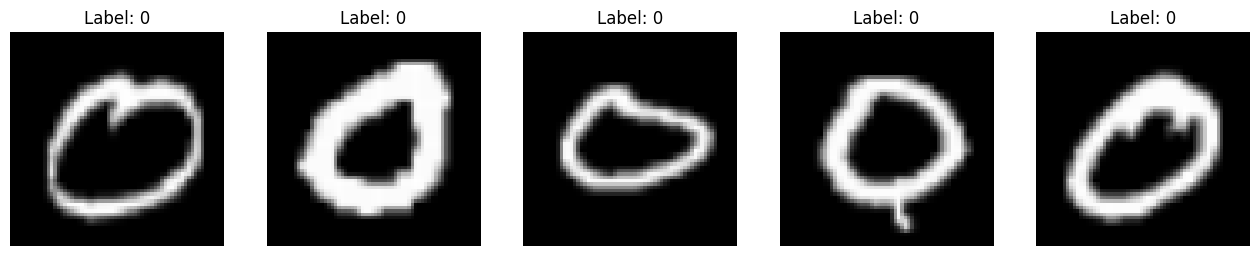

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for i, (image, label) in enumerate(image_datasets['train']):
    print(image.shape)
    axs[i].imshow(image.permute(1, 2, 0).numpy())
    axs[i].set_axis_off()
    axs[i].set_title(f"Label: {label}")


    if i >= 4: break
fig.show()

# Defining the noise scheduler


In [6]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

C:\Users\hvory\AppData\Local\Temp\ipykernel_7600\585540506.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


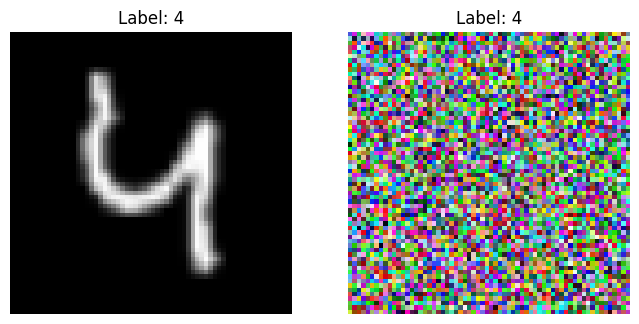

In [7]:
import torch
from PIL import Image
import matplotlib.pyplot as plt


#sample_image = train_loader[0][0].unsqueeze(0)
sample_image, labels = next(iter(train_loader))  #`sample_images` is of shape [batch_size, channels, height, width]
#print(sample_image[0])
sample_img=Image.fromarray((sample_image[0].permute(1, 2, 0)* 255).type(torch.uint8).numpy())
label=labels[0]
#print(labels)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([100])  #creates a 1-dimensional tensor of type LongTensor (64-bit integer) with a single value 50.
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
#noisy_image.permute(0, 2, 3, 1) changes the dimensions from [batch, channels, height, width] to [batch, height, width, channels],
#Multiplying by 255 scales the values to the [0, 255] range.
#.type(torch.uint8) casts the tensor to an 8-bit integer format suitable for image data.
#.numpy()[0] extracts the first (and only) image in the batch as a NumPy array.
#Finally, Image.fromarray(...) converts this array into a PIL image.
Image.fromarray((noisy_image.permute(0, 2, 3, 1) * 255).type(torch.uint8).numpy()[0])
#fig is the main figure object, which represents the entire plotting area and figsize is the total area.
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(sample_img)
axs[0].set_axis_off()
axs[0].set_title(f"Label: {label}")
axs[1].imshow(Image.fromarray((noisy_image.permute(0, 2, 3, 1) * 255).type(torch.uint8).numpy()[0]))
axs[1].set_axis_off()
axs[1].set_title(f"Label: {label}")
fig.show()
###########################################################################################


# Setting up Training

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)


In [11]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_loader) * config.num_epochs),
)

In [12]:
from accelerate import Accelerator
#from diffusers.utils.hub_utils import init_git_repo, push_to_hub
from datetime import datetime
import torch.nn.functional as F
from tqdm.auto import tqdm
import os
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging, A list of loggers to be 
    #setup for experiment tracking. Should be one or several of:"all","tensorboard","wandb"
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.log_dir, "logs")
    )
    if accelerator.is_main_process:
        #if config.push_to_hub:
            #repo = init_git_repo(config, at_init=True)
       # accelerator.init_trackers("train_example", log_with="tensorboard", logging_dir=os.path.join(config.output_dir, "logs"))
        accelerator.init_trackers("train_example")
       # accelerator.init_trackers("train_example")#, logging_dir=config.output_dir)

    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    global_step = 0
    starttime = datetime.now()
    total_batches = len(train_dataloader) * config.num_epochs

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            global_step += 1

            progress_bar.update(1)
            elapsed = datetime.now() - starttime
            total = elapsed * total_batches / global_step

            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                #if config.push_to_hub:
                    #push_to_hub(config, pipeline, repo, commit_message=f"Epoch {epoch}", blocking=True)
               # else:
                    pipeline.save_pretrained(config.output_dir) 
    torch.cuda.empty_cache()

In [13]:
def make_grid(images, rows, cols):
    w, h = images[0].size  # Get dimensions of the first image
    grid = Image.new('RGB', size=(cols*w, rows*h))  # create new blank image
    for i, image in enumerate(images):  # Paste images into the grid
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # config.eval_batch_size:This parameter specifies the number of images to generate in one batch.
    # The default pipeline output type is `List[PIL.Image]`
    #torch.manual_seed(config.seed):
    #you ensure that the image generation process can produce consistent results each time the code is run with the same seed
    #The .images attribute retrieves the generated images directly, typically as a tensor or a list of image objects.
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples") # create folder samples
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")


In [14]:
#%%capture
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_loader) * config.num_epochs),)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
args = (config, model, noise_scheduler, optimizer, train_loader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)
#num_processes: This should be set to the number of processes (GPUs) you want to use.


Launching training on one GPU.


C:\Users\hvory\AppData\Roaming\Python\Python39\site-packages\accelerate\accelerator.py:443: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


  0%|          | 0/1243 [00:00<?, ?it/s]

C:\Users\hvory\AppData\Roaming\Python\Python39\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1243 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
trained_model = DiffusionPipeline.from_pretrained("output_dir").unet.to("cuda")
def show(tensor):
    return Image.fromarray((tensor.permute(0, 2, 3, 1) * 255.0).type(torch.uint8).numpy()[0])

#show(sample_image)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Add noise
noise_level = 100 #50

def noise(img, t):
    noise = torch.randn(img.shape)#.to(device)
    timesteps = torch.LongTensor([t])#.to(device)
    noisy_image = noise_scheduler.add_noise(img, noise, timesteps)
    return noisy_image

noisy_image = noise(sample_image, noise_level)
print(sample_image.size)
print(noisy_image.shape)
save_image(noisy_image, "denoised_images/noisy_image.png")
#show(noisy_image)

In [ ]:
@torch.no_grad()
def denoise(img, ts, progress=True):
    noise_scheduler.set_timesteps(1000)
    img_reconstruct = img[0].unsqueeze(0).to("cuda")
    #img_reconstruct = img.reshape(1, 3, config.image_size, config.image_size).to("cuda")

    for t in tqdm(noise_scheduler.timesteps[-ts:], disable=not progress):
        # 1. predict noise model_output
        model_output = trained_model(img_reconstruct, t).sample

        # 2. compute previous img_reconstruct: x_t -> x_t-1
        img_reconstruct = noise_scheduler.step(model_output, t, img_reconstruct).prev_sample
        #print(reconstructed)
    return img_reconstruct


img_reconstruct = denoise(noisy_image, noise_level)

In [ ]:
reconstructed = img_reconstruct.detach().cpu()
print(type(reconstructed))
#reconstructed.save("denoised_images")
save_image(reconstructed, "denoised_images/saved_image.png")
#show(reconstructed)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

images = dict(
    sample_image=sample_image,
    noisy_image=noisy_image,
    reconstructed=reconstructed,
)

for i, (title, image) in enumerate(images.items()):
    axs[i].imshow(show(image))
    axs[i].set_axis_off()
    axs[i].set_title(title)
fig.suptitle(f"Reconstruction at $t=${noise_level}", fontsize=14);

In [ ]:
def noise(img, t):
    noise = torch.randn(img.shape)#.to(device)
    timesteps = torch.LongTensor([t])#.to(device)
    noisy_image = noise_scheduler.add_noise(img, noise, timesteps)
    return noisy_image

In [ ]:
@torch.no_grad()
def denoise(img, ts, progress=True):
    noise_scheduler.set_timesteps(1_000)
    img_reconstruct = img[0].unsqueeze(0).to("cuda")
    #img_reconstruct = img.reshape(1, 3, config.image_size, config.image_size).to("cuda")

    for t in tqdm(noise_scheduler.timesteps[-ts:], disable=not progress):
        # 1. predict noise model_output
        model_output = trained_model(img_reconstruct, t).sample

        # 2. compute previous img_reconstruct: x_t -> x_t-1
        img_reconstruct = noise_scheduler.step(model_output, t, img_reconstruct).prev_sample

    return img_reconstruct


In [ ]:
noise_level = 100 #50
from PIL import Image
import shutil
lst_dir=[]
#test_loader = data.DataLoader(image_datasets['train'], batch_size=config.test_batch_size, shuffle=True, num_workers=config.workers)
for idx, (originImg, label) in enumerate(image_datasets['train']):
        file_path = image_datasets['train'].samples[idx][0]
        file_name = os.path.splitext(os.path.basename(file_path))[0]    #[0]
        originImg=originImg.unsqueeze(0)
        os.makedirs("clean_dataset", exist_ok=True)
        noisy_image = noise(originImg, noise_level)
        img_reconstruct = denoise(noisy_image, noise_level)
        reconstructed = img_reconstruct.detach().cpu()
        folder_path = os.path.join('/scratch/project_2012241/mnist' , 'train') 
        newfile= file_name
        lst_dir.append(newfile)
        os.makedirs(folder_path + "\\" + newfile, exist_ok=True)
        newfolder=os.path.join(folder_path,newfile)
        Image.fromarray((noisy_image.permute(0, 2, 3, 1) * 255).type(torch.uint8).numpy()[0])
        image_path = os.path.join(newfolder, file_name + ".png")
        save_image(reconstructed, image_path)
        os.makedirs(folder_path + "\\" + newfile, exist_ok=True)
        newfolder=os.path.join(folder_path,newfile)
        image_path = os.path.join(newfolder, file_name + ".png")
        save_image(reconstructed, image_path)
